**Import Libraries**

In [27]:
!pip install scikit-plot

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import scikitplot as skplt


**Load the dataset**

In [29]:
# Load the data
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
             "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
             "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
             "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
             "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
             "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

ds_train = pd.read_csv(train_url, header=None, names=col_names)
ds_test = pd.read_csv(test_url, header=None, names=col_names)

In [30]:
ds.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [31]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148517 entries, 0 to 22543
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13  root_

  **Correlation matrix**

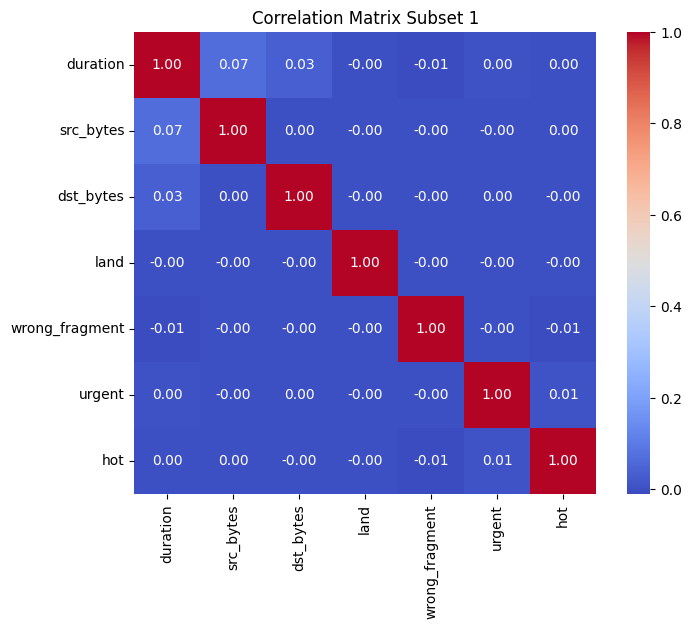

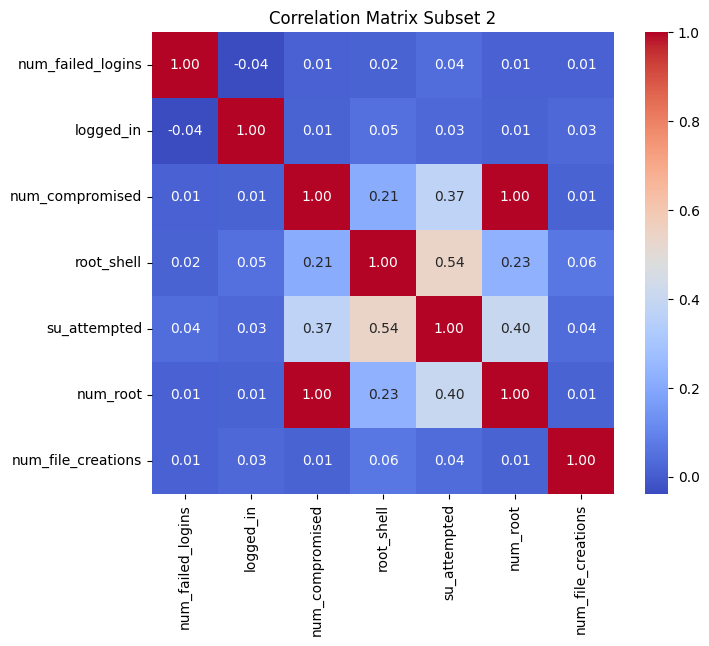

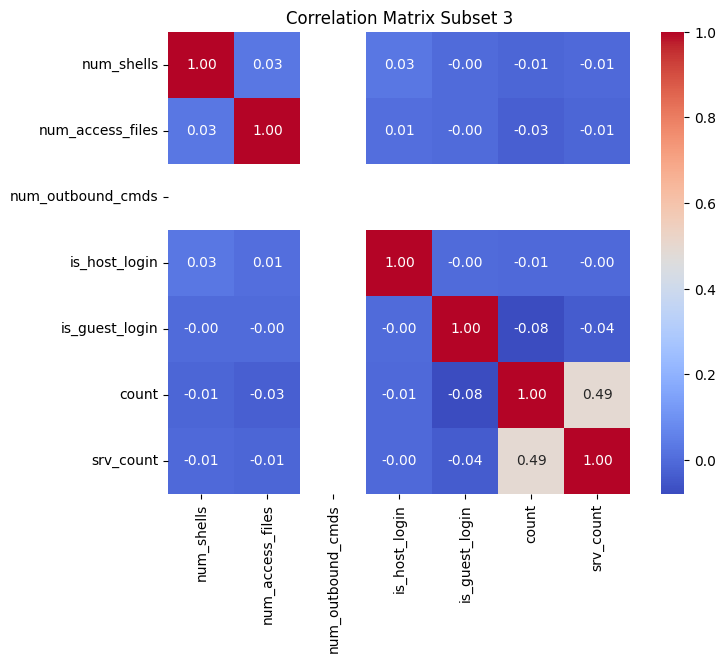

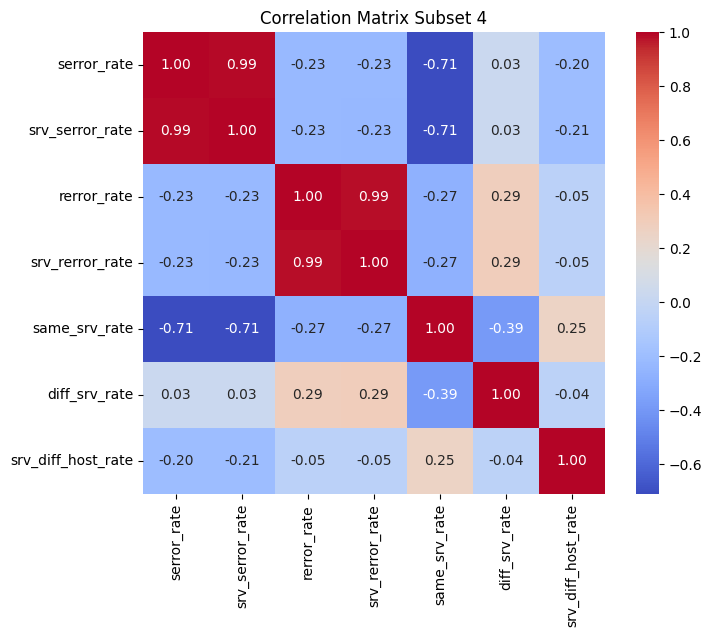

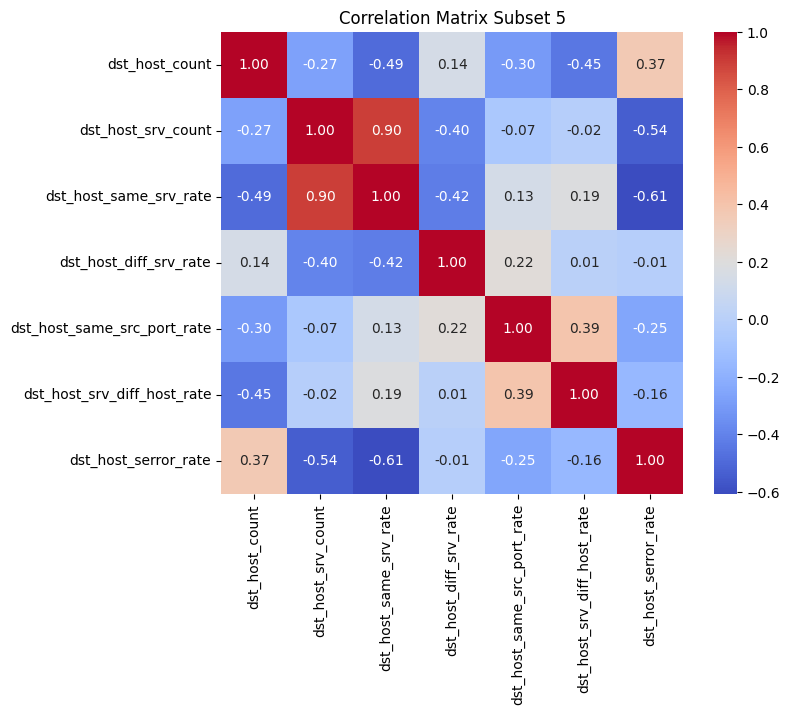

In [34]:
import seaborn as sns

# Calculate the correlation matrix for the entire dataset
numeric_ds = ds.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_ds.corr()

# Divide the correlation matrix into 5 smaller matrices
num_columns = correlation_matrix.shape[0]
num_subsets = 5
columns_per_subset = num_columns // num_subsets

# Plot each subset separately
for i in range(num_subsets):
    start_col = i * columns_per_subset
    end_col = min((i + 1) * columns_per_subset, num_columns)
    subset_matrix = correlation_matrix.iloc[start_col:end_col, start_col:end_col]

    plt.figure(figsize=(8, 6))
    sns.heatmap(subset_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f'Correlation Matrix Subset {i+1}')
    plt.show()


**Combine train and test data**

In [35]:
ds = pd.concat([ds_train, ds_test], axis=0)

**Preprocess the data**

In [36]:
ds.loc[(ds.label != 'normal'), 'label'] = 'attack'

In [37]:
# Encode categorical features
encoder = LabelEncoder()
for col in ['protocol_type', 'service', 'flag']:
    ds[col] = encoder.fit_transform(ds[col])

**Data Preprocessing**

In [38]:
# Scale numeric features
scaler = MinMaxScaler()
ds[col_names[:-1]] = scaler.fit_transform(ds[col_names[:-1]])

In [39]:
# Prepare data for RNN and CNN
X = ds.drop('label', axis=1)
y = ds['label']
X = X.to_numpy().reshape(X.shape[0], X.shape[1], 1)
y = np.array(y.map({'normal': 0, 'attack': 1}))

In [40]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Build CNN model**

In [41]:
# Build and train CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(64, 3, padding="same", activation="relu", input_shape=(X.shape[1], 1)))
model_cnn.add(Conv1D(64, 3, padding="same", activation="relu"))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(128, 3, padding="same", activation="relu"))
model_cnn.add(Conv1D(128, 3, padding="same", activation="relu"))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation="sigmoid"))

**Compile CNN model**

In [42]:
model_cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=5)

history_cnn = model_cnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[es], verbose=1)

Epoch 1/5
3713/3713 [==============================] - 78s 21ms/step - loss: 0.0915 - accuracy: 0.9651 - val_loss: 0.0526 - val_accuracy: 0.9791
Epoch 2/5
3713/3713 [==============================] - 68s 18ms/step - loss: 0.0503 - accuracy: 0.9815 - val_loss: 0.0377 - val_accuracy: 0.9850
Epoch 3/5
3713/3713 [==============================] - 74s 20ms/step - loss: 0.0414 - accuracy: 0.9852 - val_loss: 0.0363 - val_accuracy: 0.9868
Epoch 4/5
3713/3713 [==============================] - 69s 18ms/step - loss: 0.0360 - accuracy: 0.9870 - val_loss: 0.0341 - val_accuracy: 0.9874
Epoch 5/5
3713/3713 [==============================] - 68s 18ms/step - loss: 0.0332 - accuracy: 0.9882 - val_loss: 0.0347 - val_accuracy: 0.9880


**Build RNN model**

In [43]:
# Build and train RNN model
model_rnn = Sequential()
model_rnn.add(LSTM(64, input_shape=(X.shape[1], 1), return_sequences=True))
model_rnn.add(LSTM(64, return_sequences=True))
model_rnn.add(LSTM(64))
model_rnn.add(Dense(1, activation='sigmoid'))

**Compile the RNN model**

In [44]:
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=5)

history_rnn = model_rnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[es], verbose=1)

Epoch 1/5
3713/3713 [==============================] - 273s 72ms/step - loss: 0.1924 - accuracy: 0.9252 - val_loss: 0.1483 - val_accuracy: 0.9388
Epoch 2/5
3713/3713 [==============================] - 257s 69ms/step - loss: 0.1439 - accuracy: 0.9447 - val_loss: 0.1252 - val_accuracy: 0.9533
Epoch 3/5
3713/3713 [==============================] - 259s 70ms/step - loss: 0.1142 - accuracy: 0.9564 - val_loss: 0.1001 - val_accuracy: 0.9654
Epoch 4/5
3713/3713 [==============================] - 259s 70ms/step - loss: 0.0924 - accuracy: 0.9652 - val_loss: 0.0798 - val_accuracy: 0.9699
Epoch 5/5
3713/3713 [==============================] - 261s 70ms/step - loss: 0.0898 - accuracy: 0.9657 - val_loss: 0.0849 - val_accuracy: 0.9662


**Evaluate both models**

In [45]:
# Evaluate models
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test, y_test)
loss_rnn, accuracy_rnn = model_rnn.evaluate(X_test, y_test)

print("CNN Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_cnn, accuracy_cnn))
print("RNN Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_rnn, accuracy_rnn))

929/929 [==============================] - 20s 21ms/step - loss: 0.0849 - accuracy: 0.9662
CNN Model - Loss: 0.0347, Accuracy: 0.9880
RNN Model - Loss: 0.0849, Accuracy: 0.9662


**Training History**

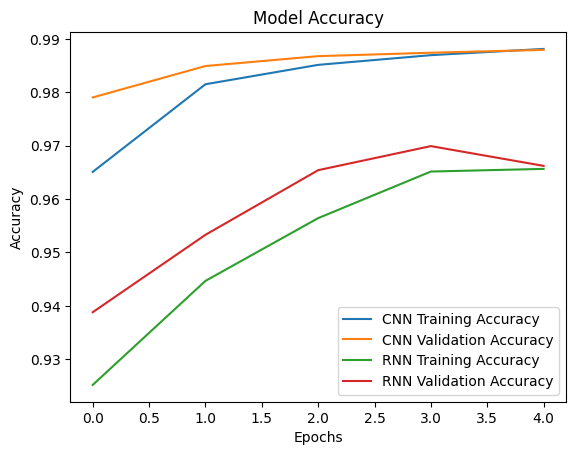

In [46]:
# Plot training history
plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(history_rnn.history['accuracy'], label='RNN Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Confusion Matrix**

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predictions for CNN and RNN models
y_pred_cnn = np.round(model_cnn.predict(X_test)).astype(int)
y_pred_rnn = np.round(model_rnn.predict(X_test)).astype(int)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()


929/929 [==============================] - 18s 20ms/step


**Confusion matrix for CNN**

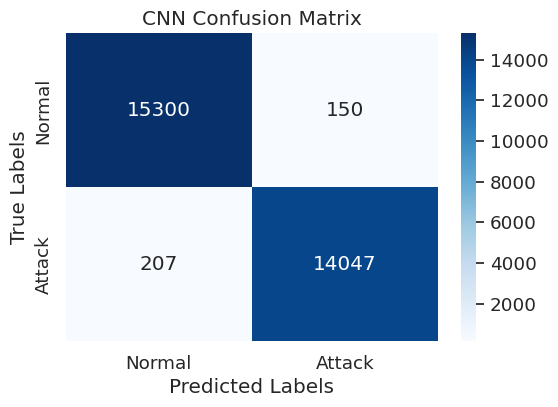

In [56]:
# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plot_confusion_matrix(cm_cnn, ['Normal', 'Attack'], title='CNN Confusion Matrix')

**Confusion matrix for RNN**

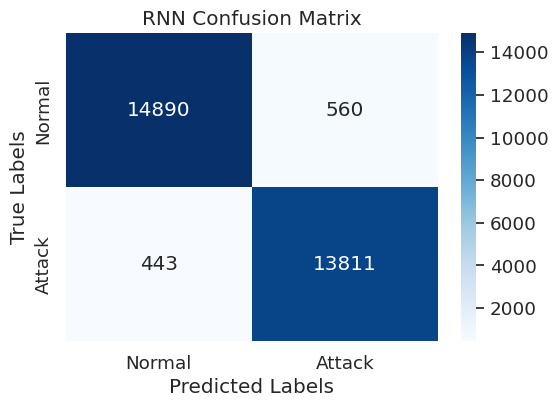

In [57]:
# Confusion Matrix for RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
plot_confusion_matrix(cm_rnn, ['Normal', 'Attack'], title='RNN Confusion Matrix')

**Accuracy Comparison**

In [50]:
# Accuracy Comparison
print("CNN Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_cnn)*100))
print("RNN Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rnn)*100))

CNN Accuracy: 98.80%
RNN Accuracy: 96.62%


**Evaluation metric for CNN**

In [51]:

# Evaluation metrics for CNN
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn)
recall_cnn = recall_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)

print("Evaluation metrics for CNN:")
print("Accuracy: {:.2f}%".format(accuracy_cnn*100))
print("Precision: {:.2f}%".format(precision_cnn*100))
print("Recall: {:.2f}%".format(recall_cnn*100))
print("F1-score: {:.2f}%".format(f1_cnn*100))
print()


Evaluation metrics for CNN:
Accuracy: 98.80%
Precision: 98.94%
Recall: 98.55%
F1-score: 98.75%



**Evaluation metric for RNN**

In [54]:

# Evaluation metrics for RNN
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn)
recall_rnn = recall_score(y_test, y_pred_rnn)
f1_rnn = f1_score(y_test, y_pred_rnn)

print("Evaluation metrics for RNN:")
print("Accuracy: {:.2f}%".format(accuracy_rnn*100))
print("Precision: {:.2f}%".format(precision_rnn*100))
print("Recall: {:.2f}%".format(recall_rnn*100))
print("F1-score: {:.2f}%".format(f1_rnn*100))
print()

Evaluation metrics for RNN:
Accuracy: 96.62%
Precision: 96.10%
Recall: 96.89%
F1-score: 96.50%



**Comparison of both Models**

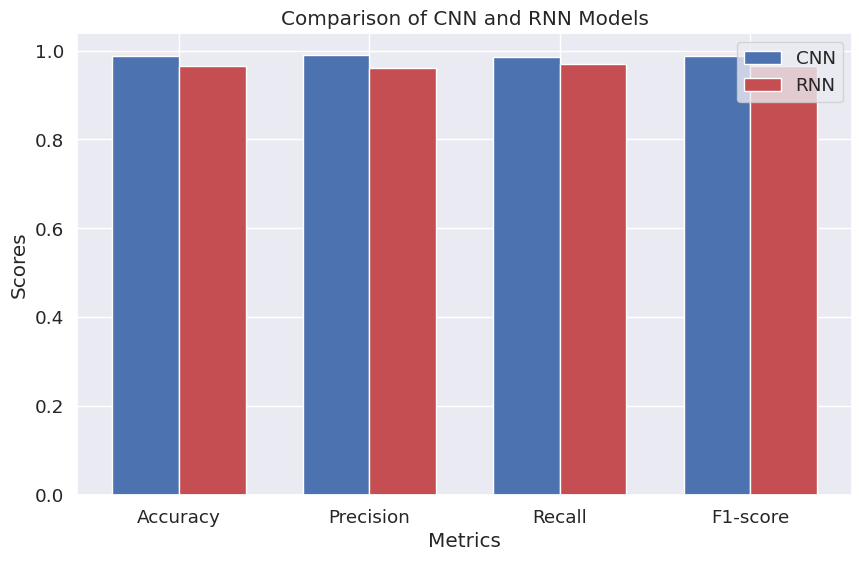

In [53]:
import matplotlib.pyplot as plt

# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
cnn_scores = [accuracy_cnn, precision_cnn, recall_cnn, f1_cnn]
rnn_scores = [accuracy_rnn, precision_rnn, recall_rnn, f1_rnn]

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, cnn_scores, bar_width, label='CNN', color='b')
plt.bar(index + bar_width, rnn_scores, bar_width, label='RNN', color='r')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of CNN and RNN Models')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.show()
